## Tensorflow - Nonlinear Dynamical Systems    

With Tensorflow, formalize how to work with what's described at the end of <i>Techniques in Fractal Geometry</i> by Kenneth Falconer: "there are certain circumstances when it is appropriate to seek solutions of a 'differential equation' defined on a set that is itself fractal, <b>for example when modelling conduction of</b> heat or <b>electricity through a highly porous material</b>."  

Here be buried theoretical biotech treasure guarded by mathematical dragons.  

#### General Models
* Lorenz Attractor  
* Reaction-Diffusion <i>(Future)</i>  
* Heat Equation on Regions with a Fractal Boundary <i>(Future)</i>  

#### Nonlinear Oscillators (Neuron Models)
* Fitzhugh-Nagumo
* Morris-Lecar  
* Hindmarsh-Rose
* Hodgkins-Huxley    


In [2]:
# Shebang

import tensorflow as tf
import numpy as np
from numpy.fft import fft, fftfreq, rfft
import matplotlib.pyplot as plt

# Using this to circumvent some garbage that gets puked up in tensorflow 1.7.0 
# in combination with Arch and python 3.6

import logging

class WarningFilter(logging.Filter):
    def filter(self, record):
        msg = record.getMessage()
        tf_warning = 'retry (from tensorflow.contrib.learn.python.learn.datasets.base)' in msg
        return not tf_warning
            
logger = logging.getLogger('tensorflow')
logger.addFilter(WarningFilter())

#### Helper Functions

In [86]:
# Generate solutions to the ODEs, solve up that ferndangled biscuit

def generate_odesolution(function, initial_conditions, t0=0, tfinal=50, n=1000):
    init_state = tf.constant(initial_conditions, dtype=tf.float64)
    t = np.linspace(t0, tfinal, num=n)
    tensor_state, tensor_info = tf.contrib.integrate.odeint(function, init_state, t, full_output=True)
    return [tensor_state, tensor_info]

# Generate a power spectrum, gotta do some twerking to get the shpongle fongled

def generate_powerspectrum(membranepotential):
    Y = np.mean(membranepotential)    # determine DC component of membrane potential signal
    X = membranepotential - Y         # subtract DC component from PS to get rid of peak at 0
    fdata = X.size
    ps = abs(fft(X))**2
    time_step = 1 / 30
    freqs = fftfreq(int(fdata/2 - 1), time_step)
    idx = np.argsort(freqs)
    return freqs, ps, idx

# Generate the max frequency of the membrane potential at a given input

def generate_maxfrequency(membranepotential):
    Y = np.mean(membranepotential)    # determine DC component of membrane potential signal
    X = membranepotential - Y         # subtract DC component from PS to get rid of peak at 0
    fdata = X.size
    ps = abs(fft(X))**2
    time_step = 1 / 30
    freqs = fftfreq(int(fdata/2 - 1), time_step)
    idx = np.argmax(np.abs(ps))
    maxfreq = freqs[idx]
    return maxfreq

#### Lorenz Attractor  

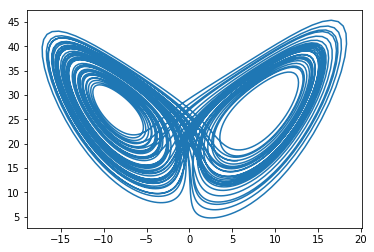

In [56]:
# Model Parameters

rho = 28.0
sigma = 10.0
beta = 8.0/3.0
inits = [0, 2, 20]

# Model Definition

def lorenz_equation(state, t):
    x, y, z = tf.unstack(state)
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return tf.stack([dx, dy, dz])

# Session Definition

sess = tf.Session()
state, info = sess.run(generate_odesolution(lorenz_equation, inits, n=5000))
x, y, z = state.T
plt.plot(x, z)

#### Reaction-Diffusion  

In [57]:
# Borked until PDEs on fractal boundaries work

#### Fitzhugh-Nagumo  

0.4208416833667335


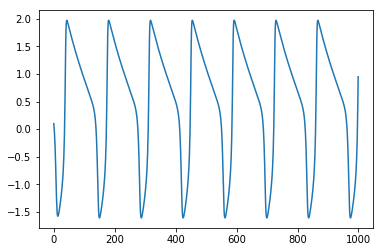

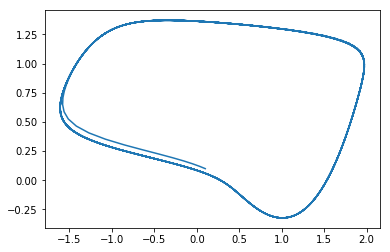

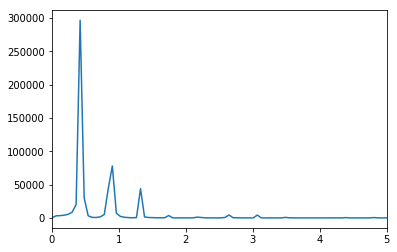

In [87]:
a = 0.75
b = 0.8
c = 3
i = -0.4
inits = [0.1, 0.1]

def fitzhughnagumo_equation(state, t):
    v, w = tf.unstack(state)
    dv = c*(v + w - (v**3/3) + i)
    dw = -1/c * (v - a + b*w)
    return tf.stack([dv, dw])

sess = tf.Session()
state, info = sess.run(generate_odesolution(fitzhughnagumo_equation, inits, tfinal=100))
v, w = state.T

# Membrane potential

plt.figure()
plt.plot(v)

# Phase plot

plt.figure()
plt.plot(v, w)

# Power Spectrum
freq, ps, idx = generate_powerspectrum(v)
plt.figure()
plt.plot(freqs[idx], ps[idx])
plt.xlim(0, 5)

# Frequency of max
print(generate_maxfrequency(v))

#### Morris-Lecar  

0.4809619238476954


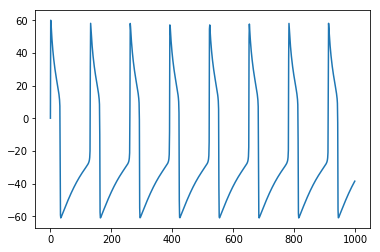

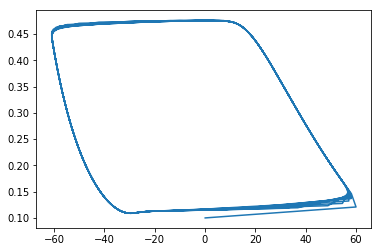

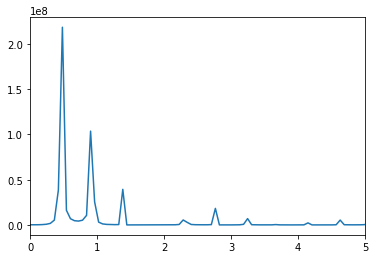

In [81]:
vk = -84
gk = 8
vca = 130
gca = 4.4
vl = -60
gl = 2
phi = 0.04
v1 = -1.2
v2 = 18
v3 = 2
v4 = 30
iapp = 80
inits = [0.1, 0.1]

def morrislecar_equation(state, t):
    v, n = tf.unstack(state)
    dv = (-gca*(0.5*(1 + tf.tanh((v - v1)/v2)))*(v - vca) - gk*n*(v - vk) - gl*(v - vl) + iapp)
    dn = (phi*((0.5*(1 + tf.tanh((v - v3)/v4))) - n))/(1/tf.cosh((v - v3)/(2*v4)))
    return tf.stack([dv, dn])

sess = tf.Session()
state, info = sess.run(generate_odesolution(morrislecar_equation, inits, tfinal=500))
v, n = state.T

plt.figure()
plt.plot(v)

plt.figure()
plt.plot(v,n)

freq, ps, idx = generate_powerspectrum(v)
plt.figure()
plt.plot(freqs[idx], ps[idx])
plt.xlim(0, 5)

print(generate_maxfrequency(v))

#### Hindmarsh-Rose  

(0, 5)

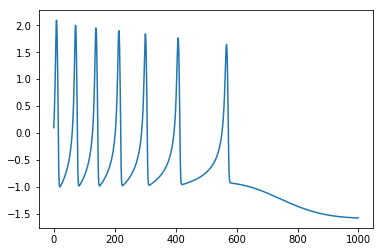

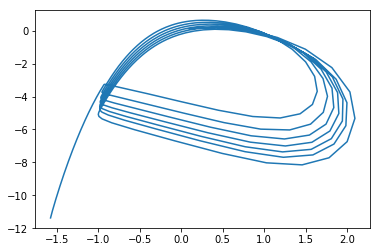

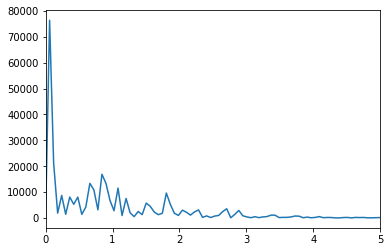

In [88]:
a = 1.0
b = 3.0
c = 1.0
d = 5.0
r = 0.006
s = 4.0
i = 1.3
xnot = -1.5
inits = [0.1, 0.1, 0.1]

def hindmarshrose_equation(state, t):
    x, y, z = tf.unstack(state)
    dx = y - a*(x**3) + (b*(x**2)) - z + i
    dy = c - d*(x**2) - y
    dz = r*(s*(x - xnot) - z)
    return tf.stack([dx, dy, dz])

sess = tf.Session()
state, info = sess.run(generate_odesolution(hindmarshrose_equation, inits, tfinal=100))
x, y, z = state.T

plt.figure()
plt.plot(x)

plt.figure()
plt.plot(x,y)

freq, ps, idx = generate_powerspectrum(x)
plt.figure()
plt.plot(freqs[idx], ps[idx])
plt.xlim(0, 5)

# print(generate_maxfrequency(x))

#### Hodgkin-Huxley  

0.4208416833667335


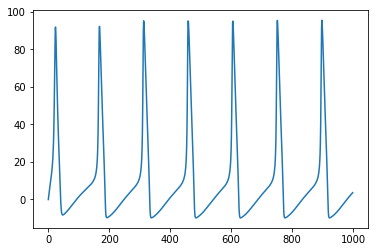

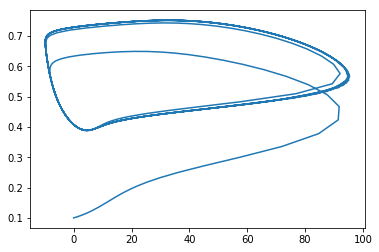

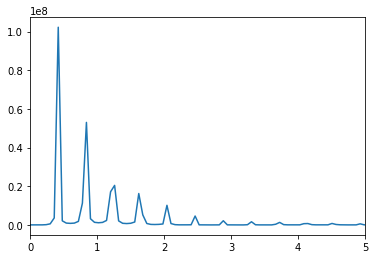

In [83]:
g_K = 36
g_Na = 120
g_L = 0.3
E_K = 12
E_Na = -115
E_L = -10.613
C_m = 1
I = -10
inits = [0.1, 0.1, 0.1, 0.1]

def hodgkinhuxley_equation(state, t):
    i, n, m, h = tf.unstack(state)
    # Alpha and beta functions for channel activation functions
    alpha_n = (0.01*(i + 10))/(tf.exp((i + 10)/10) - 1)
    beta_n = 0.125* tf.exp(i/80)
    alpha_m = (0.1*(i + 25))/(tf.exp((i + 25)/10) - 1)
    beta_m = 4*tf.exp(i/18)
    alpha_h = (0.07*tf.exp(i/20))
    beta_h = 1/(tf.exp((i + 30)/10) + 1)
    # Differential Equations
    di = (g_K*(n**4)*(i - E_K) + g_Na*(m**3)*h*(i - E_Na) + g_L*(i - E_L) - I)*(-1/C_m)
    dn = alpha_n*(1 - n) - beta_n*n
    dm = alpha_m*(1 - m) - beta_m*m
    dh = alpha_h*(1 - h) - beta_h*h
    return tf.stack([di, dn, dm, dh])

sess = tf.Session()
state, info = sess.run(generate_odesolution(hodgkinhuxley_equation, inits, tfinal=100))
i, n, m, h = state.T

plt.figure()
plt.plot(-i)

plt.figure()
plt.plot(-i, n)

freq, ps, idx = generate_powerspectrum(-i)
plt.figure()
plt.plot(freqs[idx], ps[idx])
plt.xlim(0, 5)

print(generate_maxfrequency(-i))

#### Linearly Coupled Fitzhugh-Nagumo

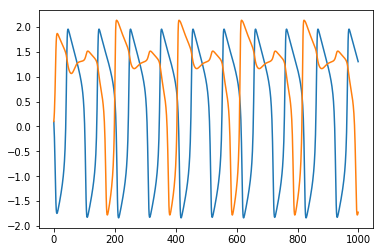

In [9]:
a = 0.75
b = 0.8
c = 3
i = -0.6
k1 = 0.03
k2 = 0.3
inits = [0.1, 0.1, 0.1, 0.1]

# Coupling method: Numerical bifurcation analysis of two coupled Fitzhugh-Nagumo oscillators
#                 Anderson Hoff, Juliana V. dos Santos, Cesar Manchein, Holokz A. Albaquerque

def lcoupled_fitzhughnagumo_equation(state, t):
    v, w, v1, w1 = tf.unstack(state)
    dv = c*(v + w - (v**3/3) + i) + k1*(v - v1)
    dw = -1/c * (v - a + b*w)
    dv1 = c*(v1 + w1 - (v1**3/3)) + k2*(v1 - v)
    dw1 = -1/c * (v1 - a + b*w1)
    return tf.stack([dv, dw, dv1, dw1])

sess = tf.Session()
state, info = sess.run(generate_odesolution(lcoupled_fitzhughnagumo_equation, inits, tfinal=100))
v, w, v1, w1 = state.T
plt.plot(v)
plt.plot(v1)

#### Linearly Coupled Morris-Lecar

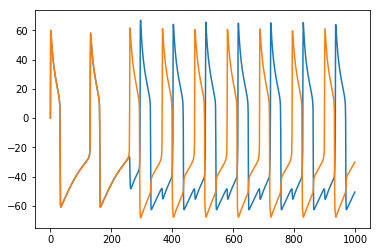

In [10]:
vk = -84
gk = 8
vca = 130
gca = 4.4
vl = -60
gl = 2
phi = 0.04
v1 = -1.2
v2 = 18
v3 = 2
v4 = 30
iapp = 80
k1 = 0.3
k2 = 0.3
inits = [0.1, 0.1, 0.11, 0.1]

def lcoupled_morrislecar_equation(state, t):
    v, n, v0, n0 = tf.unstack(state)
    dv = (-gca*(0.5*(1 + tf.tanh((v - v1)/v2)))*(v - vca) - gk*n*(v - vk) - gl*(v - vl) + iapp + k1*(v - v0))
    dn = (phi*((0.5*(1 + tf.tanh((v - v3)/v4))) - n))/(1/tf.cosh((v - v3)/(2*v4)))
    dv0 = (-gca*(0.5*(1 + tf.tanh((v0 - v1)/v2)))*(v0 - vca) - gk*n0*(v0 - vk) - gl*(v0 - vl) + iapp + k2*(v0 - v))
    dn0 = (phi*((0.5*(1 + tf.tanh((v0 - v3)/v4))) - n0))/(1/tf.cosh((v0 - v3)/(2*v4)))
    return tf.stack([dv, dn, dv0, dn0])

sess = tf.Session()
state, info = sess.run(generate_odesolution(lcoupled_morrislecar_equation, inits, tfinal=500))
v, n, v0, n0 = state.T
plt.plot(v)
plt.plot(v0)

#### Linearly Coupled Hindmarsh-Rose  

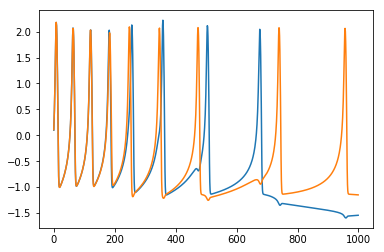

In [11]:
a = 1.0
b = 3.0
c = 1.0
d = 5.0
r = 0.006
s = 4.0
i = 1.6
xnot = -1.5
k1 = 0.3
k2 = 0.3
inits = [0.1, 0.1, 0.1, 0.11, 0.1, 0.1]

def lcoupled_hindmarshrose_equation(state, t):
    x, y, z, x1, y1, z1 = tf.unstack(state)
    dx = (y - a*(x**3) + (b*(x**2)) - z + i) + k1*(x - x1)
    dy = c - d*(x**2) - y
    dz = r*(s*(x - xnot) - z)
    dx1 = (y1 - a*(x1**3) + (b*(x1**2)) - z1 + i) + k2*(x1 - x)
    dy1 = c - d*(x1**2) - y1
    dz1 = r*(s*(x1 - xnot) - z1)
    return tf.stack([dx, dy, dz, dx1, dy1, dz1])

sess = tf.Session()
state, info = sess.run(generate_odesolution(lcoupled_hindmarshrose_equation, inits, tfinal=100))
x, y, z, x1, y1, z1 = state.T
plt.plot(x)
plt.plot(x1)

#### Linearly Coupled Hodgkin-Huxley

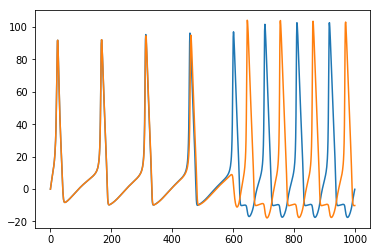

In [12]:
g_K = 36
g_Na = 120
g_L = 0.3
E_K = 12
E_Na = -115
E_L = -10.613
C_m = 1
I = -10
k1 = 0.3
k2 = 0.3
inits = [0.1, 0.1, 0.1, 0.1, 0.11, 0.1, 0.1, 0.1]

def lcoupled_hodgkinhuxley_equation(state, t):
    i, n, m, h, i1, n1, m1, h1 = tf.unstack(state)
    # Alpha and beta functions for channel activation functions
    alpha_n = (0.01*(i + 10))/(tf.exp((i + 10)/10) - 1)
    beta_n = 0.125* tf.exp(i/80)
    alpha_m = (0.1*(i + 25))/(tf.exp((i + 25)/10) - 1)
    beta_m = 4*tf.exp(i/18)
    alpha_h = (0.07*tf.exp(i/20))
    beta_h = 1/(tf.exp((i + 30)/10) + 1)
    alpha_n1 = (0.01*(i1 + 10))/(tf.exp((i1 + 10)/10) - 1)
    beta_n1 = 0.125* tf.exp(i1/80)
    alpha_m1 = (0.1*(i1 + 25))/(tf.exp((i1 + 25)/10) - 1)
    beta_m1 = 4*tf.exp(i1/18)
    alpha_h1 = (0.07*tf.exp(i1/20))
    beta_h1 = 1/(tf.exp((i1 + 30)/10) + 1)
    # Differential Equations
    di = (g_K*(n**4)*(i - E_K) + g_Na*(m**3)*h*(i - E_Na) + g_L*(i - E_L) - I)*(-1/C_m) + k1*(i - i1)
    dn = alpha_n*(1 - n) - beta_n*n
    dm = alpha_m*(1 - m) - beta_m*m
    dh = alpha_h*(1 - h) - beta_h*h
    di1 = (g_K*(n1**4)*(i1 - E_K) + g_Na*(m1**3)*h1*(i1 - E_Na) + g_L*(i1 - E_L) - I)*(-1/C_m) + k2*(i1 - i)
    dn1 = alpha_n1*(1 - n1) - beta_n1*n1
    dm1 = alpha_m1*(1 - m1) - beta_m1*m1
    dh1 = alpha_h1*(1 - h1) - beta_h1*h1
    return tf.stack([di, dn, dm, dh, di1, dn1, dm1, dh1])

sess = tf.Session()
state, info = sess.run(generate_odesolution(lcoupled_hodgkinhuxley_equation, inits, tfinal=100))
i, n, m, h, i1, n1, m1, h1 = state.T
plt.plot(-i)
plt.plot(-i1)